In [56]:
import cv2
from scipy import ndimage
from skimage.feature import peak_local_max
from skimage.morphology import watershed
from skimage.measure import regionprops

import numpy as np
from matplotlib import pyplot as plt

In [67]:
inital_threshold = 0.7
localmax_mindist = 2
min_area_mm = 3.14*(5**2)
pixel_area = 2.6**2
min_area = int(min_area_mm/pixel_area)

In [80]:
#test image
image_ffn = '/data/hailpixel_20200119/testing_subset/0328.png'

#transform into hsv colorspace
img_data = cv2.imread(image_ffn)
img_data_hls = cv2.cvtColor(img_data, cv2.COLOR_BGR2HLS)

l_data = img_data_hls[:,:,1]/255
#apply inital threshold
l_mask = l_data > inital_threshold
#compute distance transform to find centroids
l_mask_dist = ndimage.distance_transform_edt(l_mask)
localMax = peak_local_max(l_mask_dist, indices=False, min_distance=localmax_mindist,
	labels=l_mask)

#run watershed
markers = ndimage.label(localMax, structure=np.ones((3, 3)))[0]
labels = watershed(-l_mask_dist, markers, mask=l_mask,watershed_line=True)

#remove small regions
region_prop_list = regionprops(labels)
#build centroid list
hail_centroid_x = []
hail_centroid_y = []
for region_prop in region_prop_list:
    if region_prop.area > min_area:
        label_centroid = region_prop.centroid
        hail_centroid_x.append(label_centroid[1])
        hail_centroid_y.append(label_centroid[0])
hail_centroid_idx = list(range(len(hail_centroid_x)))

        
np.savez('test-detection.npz',hail_cx=hail_centroid_x,hail_cy=hail_centroid_y, hail_idx=hail_centroid_idx)

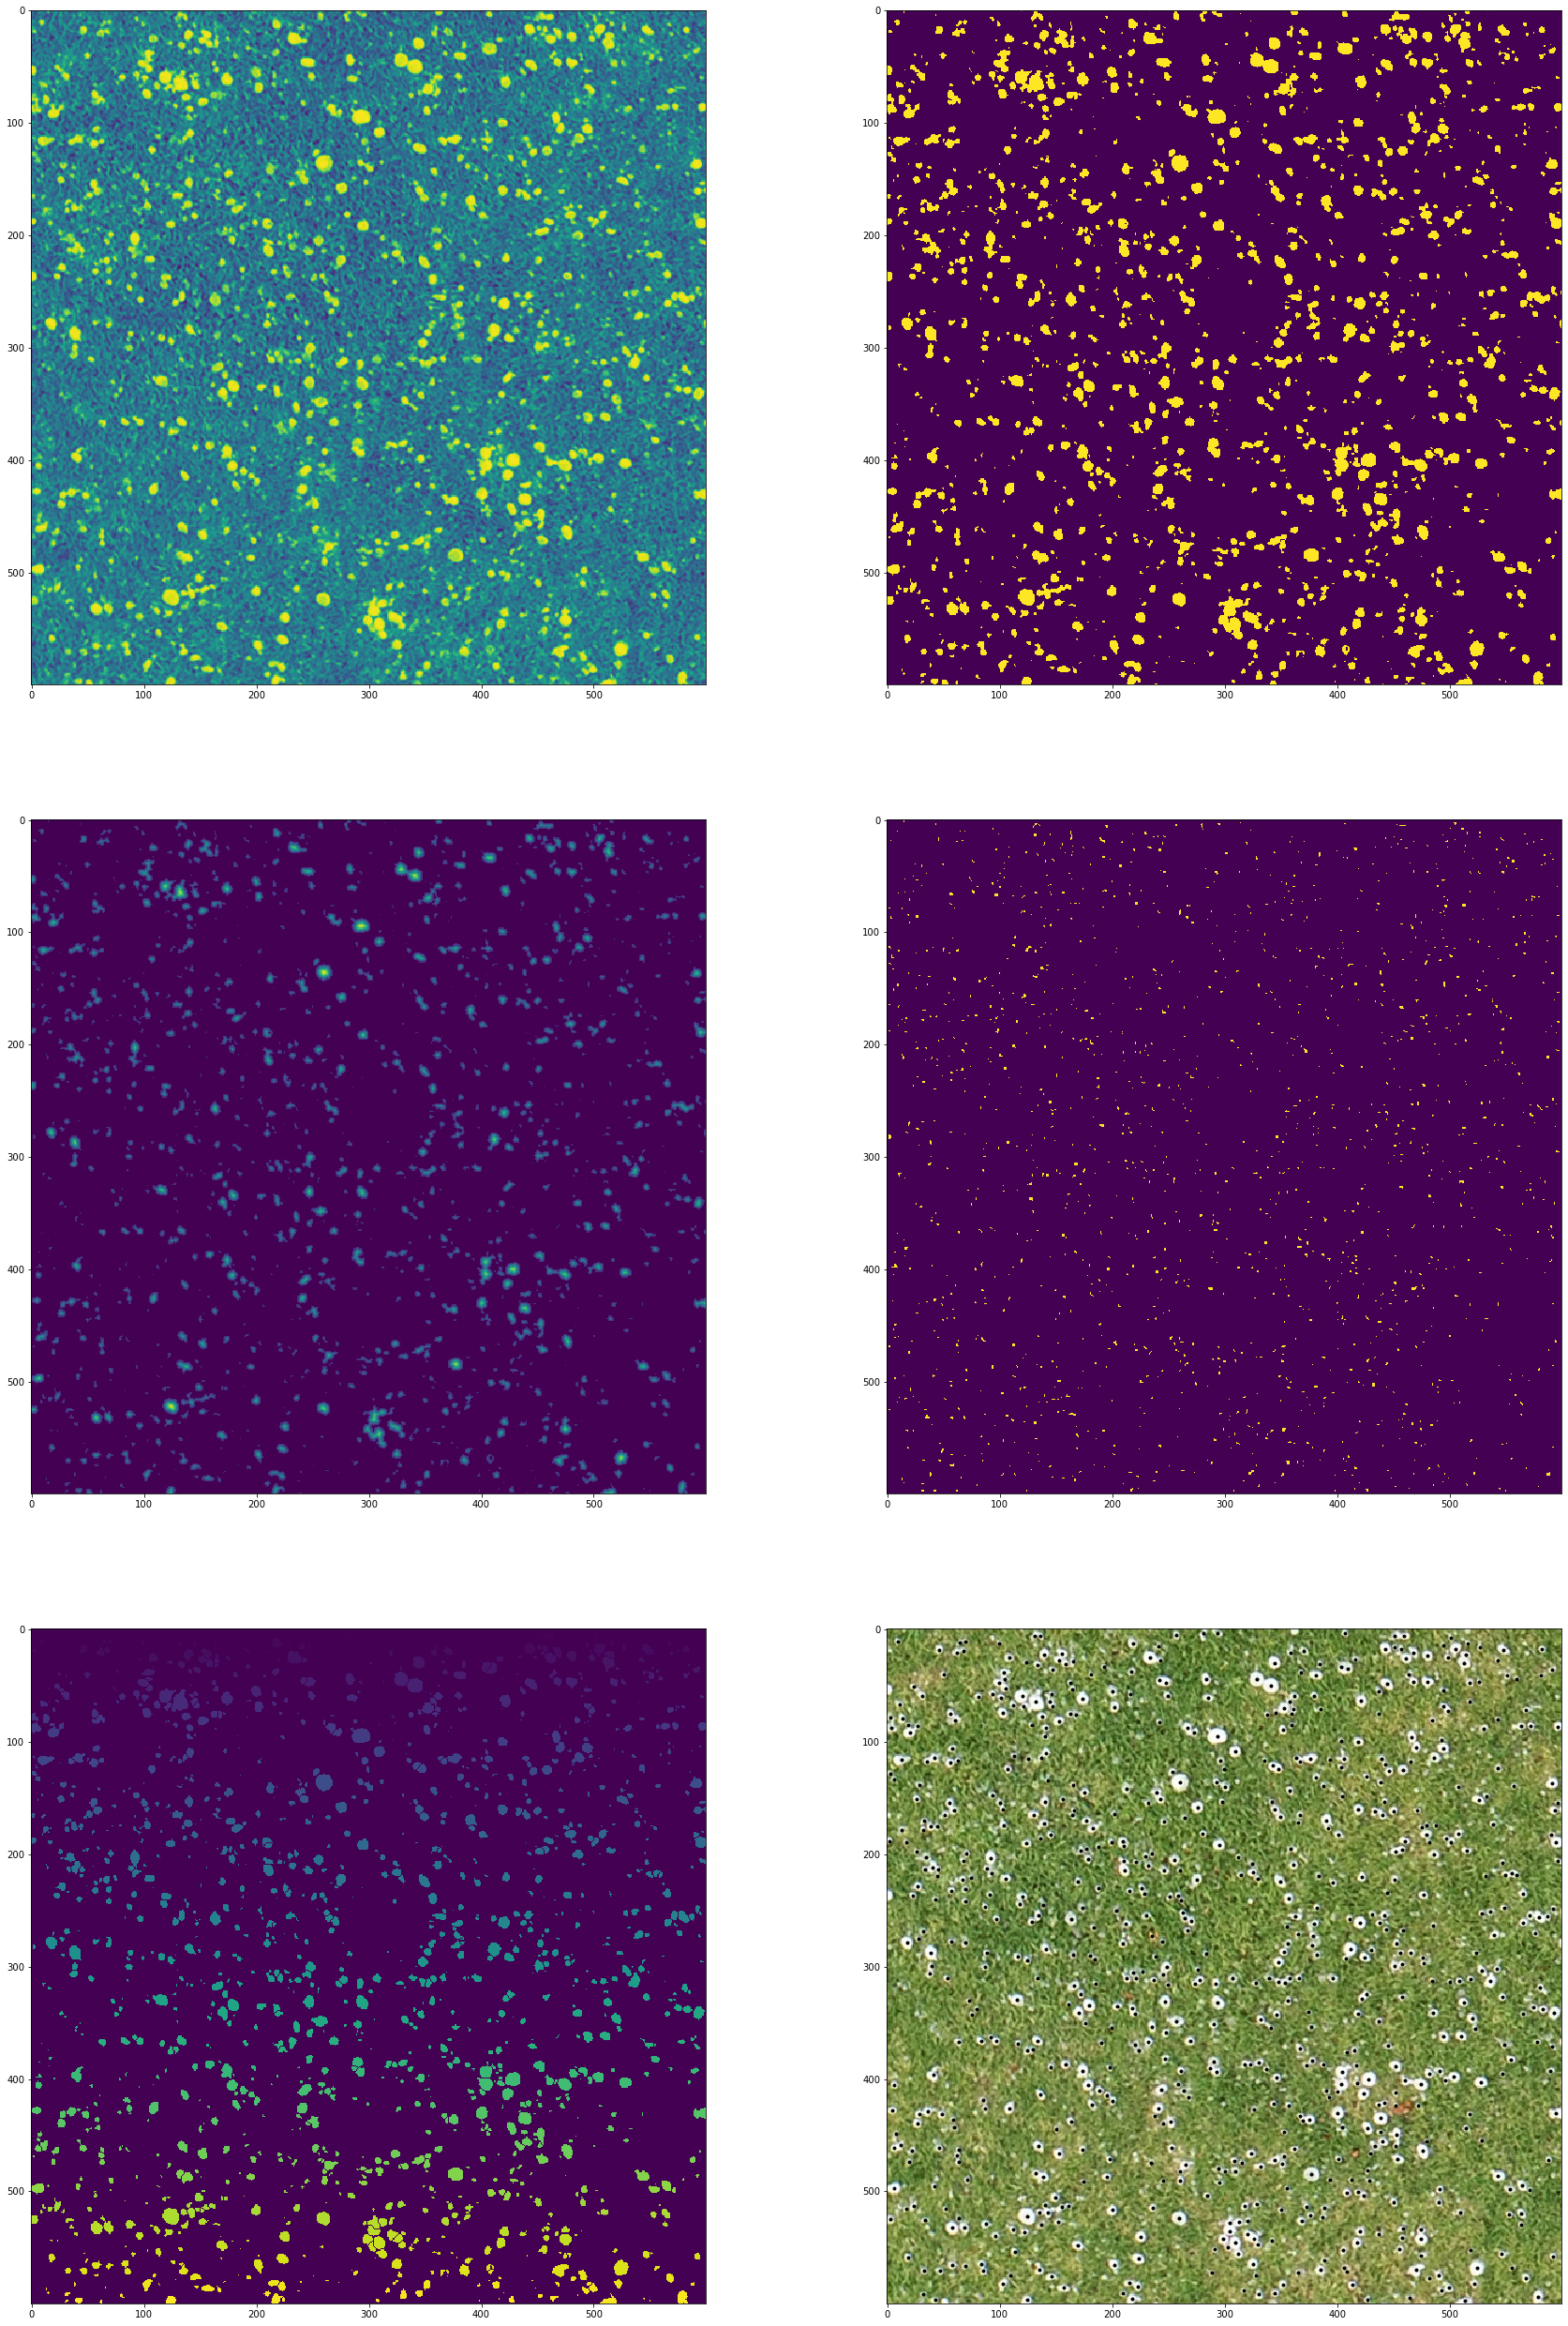

In [73]:
#full plot
fig, axes = plt.subplots(nrows=3, ncols=2, facecolor='white',figsize=[30, 45])

im = axes[0,0].imshow(l_data, vmin=0, vmax=1)
im = axes[0,1].imshow(l_mask, vmin=0, vmax=1)
im = axes[1,0].imshow(l_mask_dist)
im = axes[1,1].imshow(localMax)
im = axes[2,0].imshow(labels)
im = axes[2,1].imshow(img_data[:,:,::-1]) #invert colours # RGB-> BGR
axes[2,1].plot(hail_centroid_x, hail_centroid_y, 'k.')

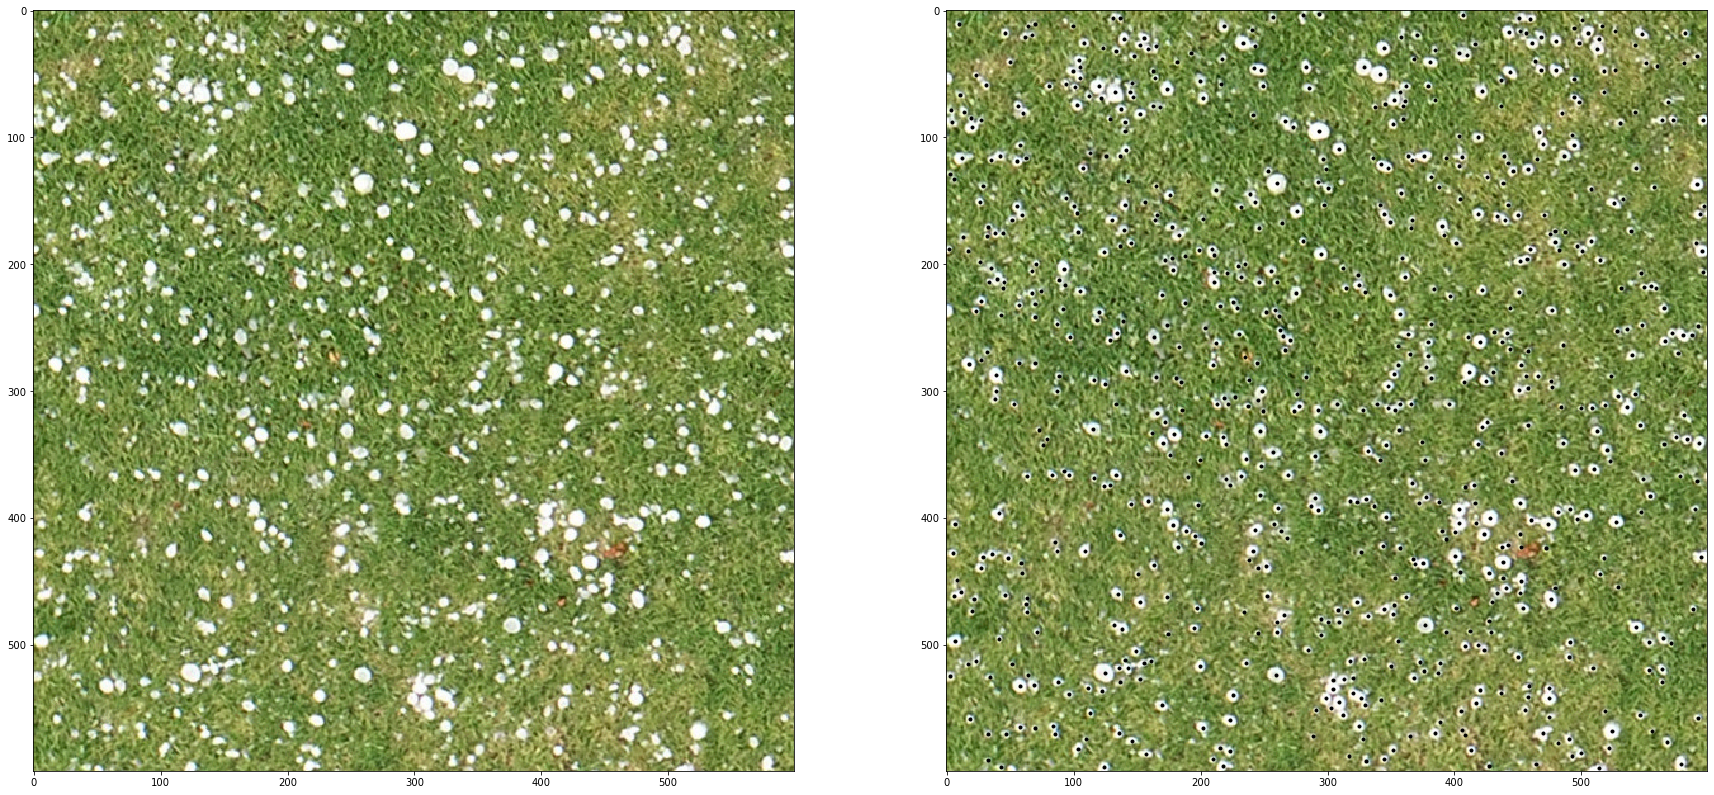

In [71]:
#simple plot
fig, axes = plt.subplots(nrows=1, ncols=2, facecolor='white',figsize=[30, 15])
im = axes[0].imshow(img_data[:,:,::-1]) #invert colours # RGB-> BGR
im = axes[1].imshow(img_data[:,:,::-1]) #invert colours # RGB-> BGR
axes[1].plot(hail_centroid_x, hail_centroid_y, 'k.')
        